In [1]:
from utility import *
from summary_models import Summary_net_lc_smol, Summary_net_lc_super_smol
from cl_models import RNVP, NSF_CL
from ar_models import NSF_AR, MAF
from plot import pairplot
from dataloader import *
#my_module_path = os.path.join("../", '21cm-wrapper')
#sys.path.append(my_module_path)
#from Leaf import *
#from sbi import analysis

%matplotlib inline

device = 'cuda'

#torch.set_num_interop_threads(4) # Inter-op parallelism
#torch.set_num_threads(6) # Intra-op parallelism

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


NVIDIA GeForce RTX 4060 Laptop GPU


|████████████████████████████████████████| 0 in 0.1s (0.00/s)                   


/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


UnboundLocalError: cannot access local variable 'zlc_min' where it is not associated with a value

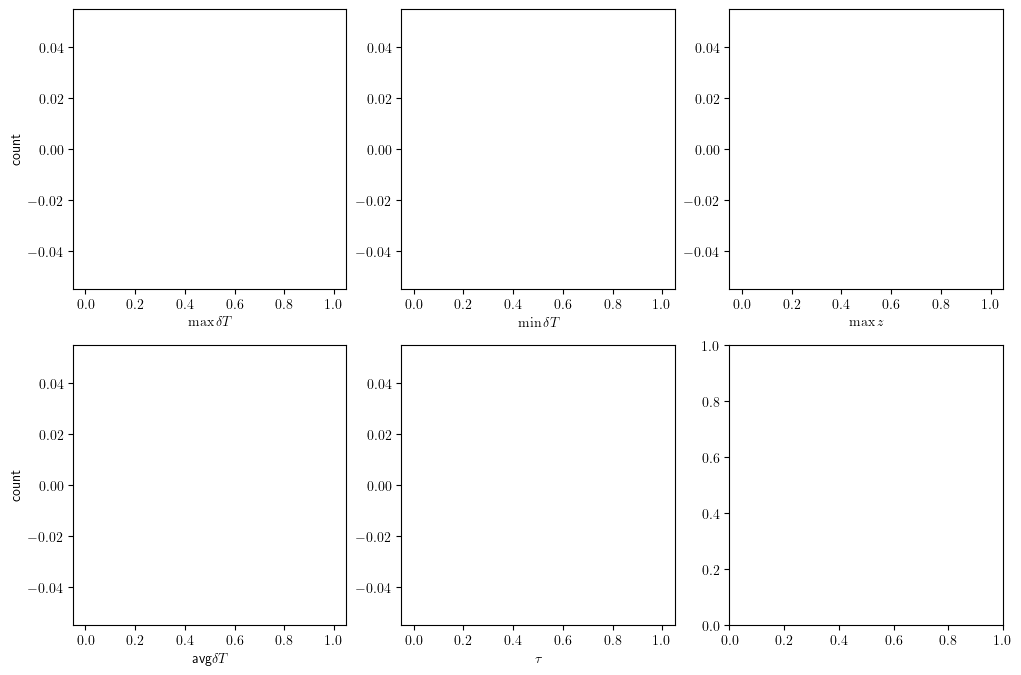

In [2]:
convert_to_torch(path='/home/potato/Documents/projects/master/data/datax5/',
                 prefix='simrun_', redshift_cutoff=680, statistics=True)

In [2]:
# hyperparams
data_path = "/home/potato/Documents/projects/master/data/datax5/"
batch_size = 32
epochs = 40
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

norm_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)


# transform trainingsdata
# perhaps add check if file is there: continue + override option in the future
#convert_to_torch(path = data_path, prefix="run", redshift_cutoff=600, debug=False, statistics=True)

# load data
train_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0.5)
test_data = DataHandler(path=data_path, prefix="batch_",
                         split = train_test_data_ration, training_data = False,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=0)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True,
                             num_workers = 2, pin_memory = True, prefetch_factor=2)

# init model
model_sn = SumnetHandler(Model = Summary_net_lc_super_smol,
                     Training_data=train_dataloader, Test_data=test_dataloader, device=device)

'''# train
model_sn.train(
    epochs=epochs,
    optimizer=optimizer(
        model_sn.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model_sn.test(Validation_data = test_dataloader, Model = model_sn.Model, 
                lossf=loss(**loss_params))'''
                
model_sn.load("./summary_net.pt")

#model_de = flow_net(in_dim=6, cond_dim=6, n_blocks=6, n_nodes=128)

summary(model_sn.Model, (1,28,28,470))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 48, 26, 26, 47]           4,368
              GELU-2       [-1, 48, 26, 26, 47]               0
       BatchNorm3d-3       [-1, 48, 26, 26, 47]              96
            Conv3d-4       [-1, 48, 24, 24, 45]          62,256
              GELU-5       [-1, 48, 24, 24, 45]               0
       BatchNorm3d-6       [-1, 48, 24, 24, 45]              96
         MaxPool3d-7       [-1, 48, 12, 12, 22]               0
            Conv3d-8       [-1, 64, 10, 10, 20]          83,008
              GELU-9       [-1, 64, 10, 10, 20]               0
      BatchNorm3d-10       [-1, 64, 10, 10, 20]             128
        ZeroPad2d-11       [-1, 64, 10, 10, 22]               0
           Conv3d-12         [-1, 96, 8, 8, 20]         165,984
             GELU-13         [-1, 96, 8, 8, 20]               0
      BatchNorm3d-14         [-1, 96, 8

In [ ]:
model_sn.test_specific(Validation_data = test_dataloader, Model = model_sn.Model, lossf=nn.MSELoss(), num_samples=10, denormalize=test_dataloader.dataset.denormalize)

loss: 12254.484375
 pred: tensor([[5.1009e+00, 3.3225e-01, 4.0430e+01, 1.0889e+03, 4.9218e+00, 6.7955e+01],
        [4.5677e+00, 3.7144e-01, 3.8797e+01, 1.0209e+03, 4.8857e+00, 3.2523e+01],
        [5.0362e+00, 3.5030e-01, 3.8861e+01, 4.5200e+02, 5.0633e+00, 1.9183e+02],
        [5.4094e+00, 2.8292e-01, 4.1050e+01, 1.0099e+03, 4.7803e+00, 1.3681e+02],
        [4.7305e+00, 2.9141e-01, 3.9686e+01, 1.1378e+03, 5.1312e+00, 1.8791e+02],
        [5.2467e+00, 3.0921e-01, 3.9868e+01, 1.0910e+03, 4.4850e+00, 8.5030e+01],
        [5.3257e+00, 2.2710e-01, 3.8449e+01, 1.0243e+03, 4.6435e+00, 1.8606e+02],
        [5.2231e+00, 2.9435e-01, 3.9507e+01, 4.0205e+02, 5.0666e+00, 2.1594e+02],
        [5.3714e+00, 2.1070e-01, 3.8417e+01, 9.7980e+02, 5.0895e+00, 2.1180e+02],
        [5.1939e+00, 2.2355e-01, 3.8744e+01, 1.0977e+03, 5.1044e+00, 1.9638e+02],
        [5.3865e+00, 3.8121e-01, 4.0026e+01, 5.2942e+02, 5.0241e+00, 8.8513e+01],
        [4.6829e+00, 3.0778e-01, 3.8610e+01, 7.6806e+02, 5.1008e+00, 1.9

In [3]:
model_sn.save("./summary_net_40.pt")

|████████████████████████████████████████| 6/6 [100%] in 4:55.2 (0.02/s)        


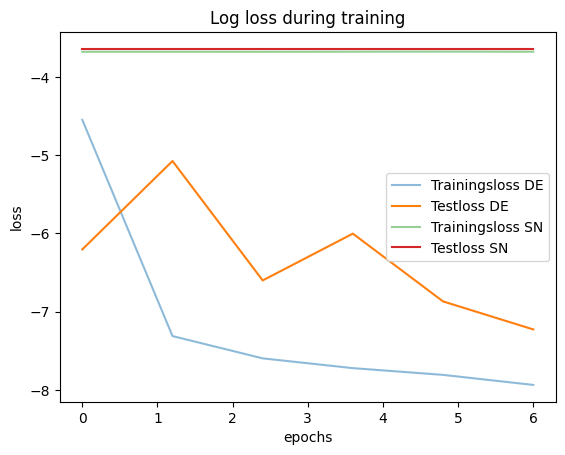

<Figure size 640x480 with 0 Axes>

In [7]:
batch_size = 64
epochs = 6
summary_net_freezed_epochs = 999
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 5e-4,
}

# add conditioner as in https://github.com/sbi-dev/sbi/blob/main/sbi/neural_nets/net_builders/flow.py

model_de = NSF_AR(in_dim=6, cond_dim=6, n_blocks=6, n_nodes=64, K=10, B=3,
               hidden_layer=1, batch_norm=True, device=device)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)

sbi.train(training_data = train_dataloader, test_data = test_dataloader,
          epochs = epochs, summary_net_freezed_epochs = summary_net_freezed_epochs, 
          summary_net_pretrain_epochs = 0, optimizer = optimizer,
              optimizer_kwargs= optimizer_params, 
              loss_params = {}, device=device, plot= True)

/tmp/ipykernel_43076/1544696197.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


NameError: name 'blub' is not defined

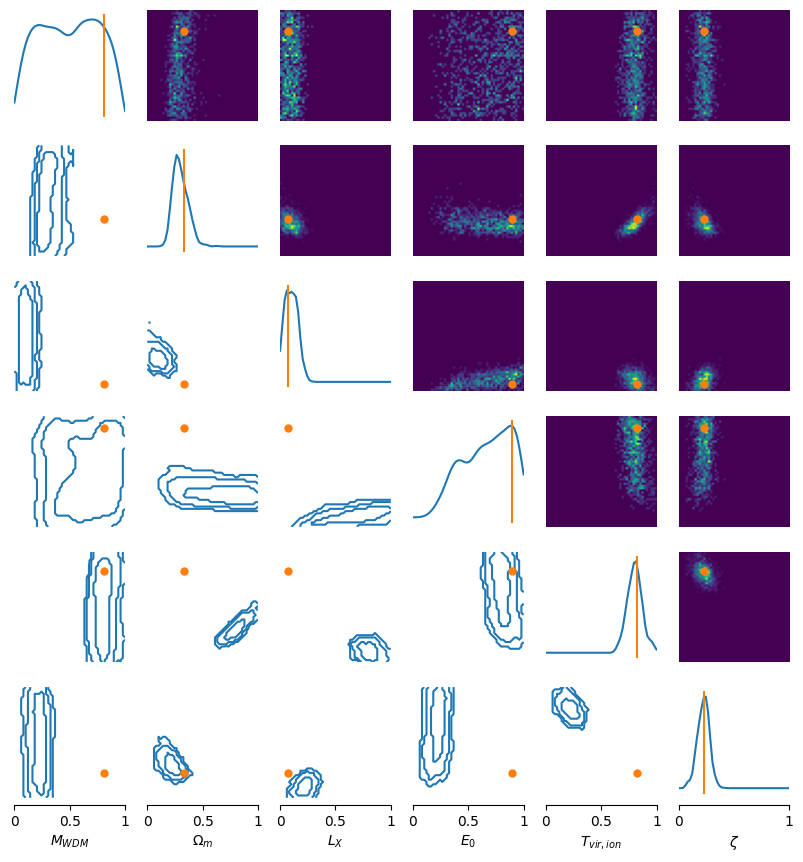

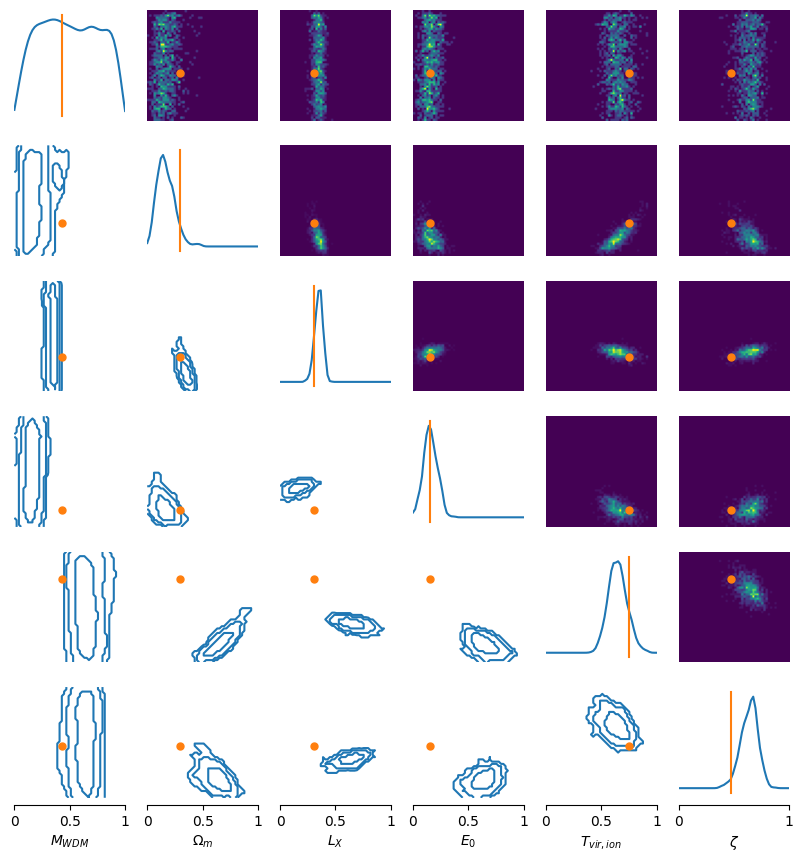

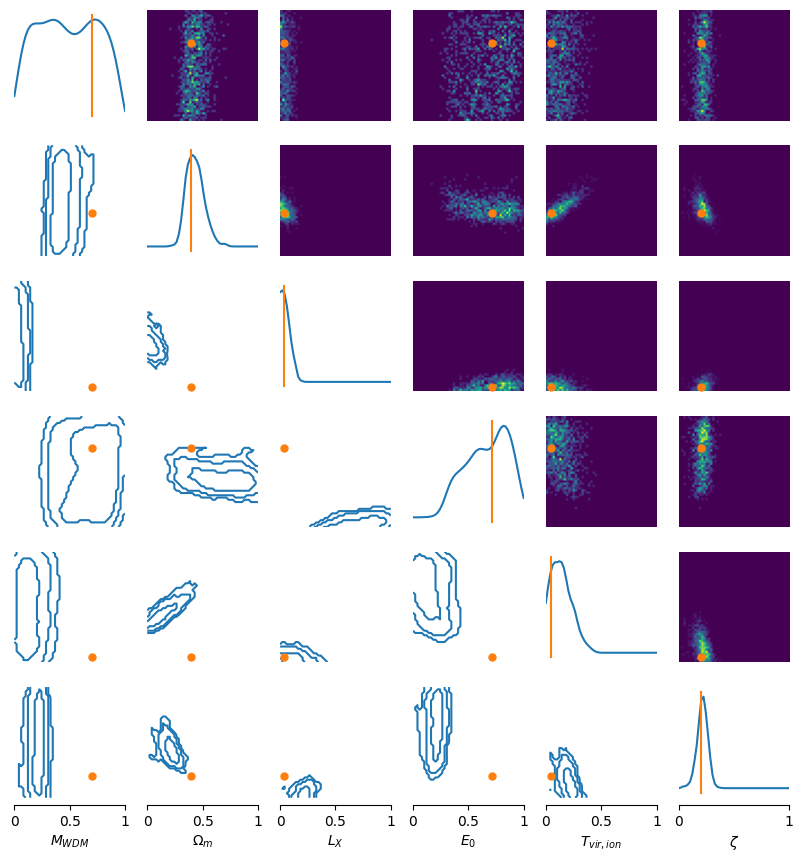

In [8]:
save = True

'''prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)
sbi.load_model()'''

for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples, _ = sbi.density_estimator.sample(nsamples, summary)
    # plot posterior samples
    figure, axis = pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"nsf_mine_premiumbounds_new_{i}.png", dpi=300)
    figure.show()

print(blub)

with torch.no_grad():
    for i, (lab, img,_) in enumerate(test_dataloader):
        img, lab = img.to(device), lab.to(device)
        
        if not i:
            summary_vec = torch.empty(0,lab.shape[1], device=device)
            labels = torch.empty(0,lab.shape[1], device=device)

        pred = sbi.summary_net(img)
        summary_vec = torch.cat((summary_vec, pred), dim=0)
        labels = torch.cat((labels, lab), dim=0)

num_samples = 10000
rank_inn = torch.empty(summary_vec.shape)
dap_samples = torch.empty((summary_vec.shape[0], summary_vec.shape[1]))
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples, _ = sbi.density_estimator.sample(cond = summary_vec[i].unsqueeze(0), num_sampels=num_samples)
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_inn[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()
        
'''rank_maf = torch.empty(summary_vec.shape)
# sbc rank stat
with alive_bar(summary_vec.shape[0], force_tty=True, refresh_secs=1) as bar:
    for i in range(summary_vec.shape[0]):
        samples = posterior.posterior_estimator.sample((10000,), summary_vec[i].unsqueeze(0))[:,0,:]
        samples = samples.detach()
        dap_samples[i] = samples[0]
        for j in range(summary_vec.shape[1]):
            rank_maf[i,j] = (samples[:,j]<labels[i,j]).sum().item()
        bar()'''


In [5]:
samples

tensor([[ 1.2052e+00,  3.4833e-01,  1.0079e-01,  9.3635e-01,  9.0302e-02,
          2.5668e-01],
        [ 2.3933e-01,  3.9825e-01,  1.3291e-01,  9.5667e-01, -5.2211e-03,
          1.5484e-01],
        [ 3.8617e-01,  6.0126e-01, -8.0884e-02,  5.0337e-01,  2.8118e-01,
          1.8120e-01],
        ...,
        [ 3.4133e-01,  5.4380e-01,  4.0302e-02,  9.3005e-01,  2.0028e-01,
          2.1295e-01],
        [ 9.0078e-01, -1.9506e+00, -2.1769e+00, -9.5832e-01, -3.0652e-01,
          1.3076e+00],
        [ 4.0428e-01,  6.4623e-01, -1.3170e-03,  5.8734e-01,  2.5415e-01,
          1.7829e-01]], device='cuda:0')

In [57]:
plt.hist2d?

Signature:
plt.hist2d(
    x: 'ArrayLike',
    y: 'ArrayLike',
    bins: 'None | int | tuple[int, int] | ArrayLike | tuple[ArrayLike, ArrayLike]' = 10,
    range: 'ArrayLike | None' = None,
    density: 'bool' = False,
    weights: 'ArrayLike | None' = None,
    cmin: 'float | None' = None,
    cmax: 'float | None' = None,
    *,
    data=None,
    **kwargs,
) -> 'tuple[np.ndarray, np.ndarray, np.ndarray, QuadMesh]'
Docstring:
Make a 2D histogram plot.

Parameters
----------
x, y : array-like, shape (n, )
    Input values

bins : None or int or [int, int] or array-like or [array, array]

    The bin specification:

    - If int, the number of bins for the two dimensions
      (``nx = ny = bins``).
    - If ``[int, int]``, the number of bins in each dimension
      (``nx, ny = bins``).
    - If array-like, the bin edges for the two dimensions
      (``x_edges = y_edges = bins``).
    - If ``[array, array]``, the bin edges in each dimension
      (``x_edges, y_edges = bins``).

    The d

In [39]:
samples.shape == idx.shape

True

In [21]:
np.histogram2d?

Signature:       np.histogram2d(x, y, bins=10, range=None, density=None, weights=None)
Call signature:  np.histogram2d(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function histogram2d at 0x7ef278010860>
File:            ~/Documents/projects/master/ml-venv/lib/python3.11/site-packages/numpy/lib/twodim_base.py
Docstring:      
Compute the bi-dimensional histogram of two data samples.

Parameters
----------
x : array_like, shape (N,)
    An array containing the x coordinates of the points to be
    histogrammed.
y : array_like, shape (N,)
    An array containing the y coordinates of the points to be
    histogrammed.
bins : int or array_like or [int, int] or [array, array], optional
    The bin specification:

      * If int, the number of bins for the two dimensions (nx=ny=bins).
      * If array_like, the bin edges for the two dimensions
        (x_edges=y_edges=bins).
      * If [int, int], the number of bins in each dimension
        (nx, ny = bins).
 

In [18]:
labels_txt = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"]
print(rank_inn.shape)
fig, ax = plt.subplots(1,6, figsize=(30,5))
for i in range(6):
    ax[i].hist(rank_inn[:,i].cpu().numpy(), bins=50, range=(0, num_samples), density=True)
    ax[i].set_title(f"{labels_txt[i]}")
    ax[i].set_xlabel("Rank")
    kde = stats.gaussian_kde(rank_inn[:,i].cpu().numpy())
    xx = np.linspace(0, num_samples, num_samples)
    ax[i].plot(xx, kde(xx), c='orange')
plt.show()




NameError: name 'rank_inn' is not defined

torch.Size([10000, 6])


/tmp/ipykernel_44786/1665307448.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


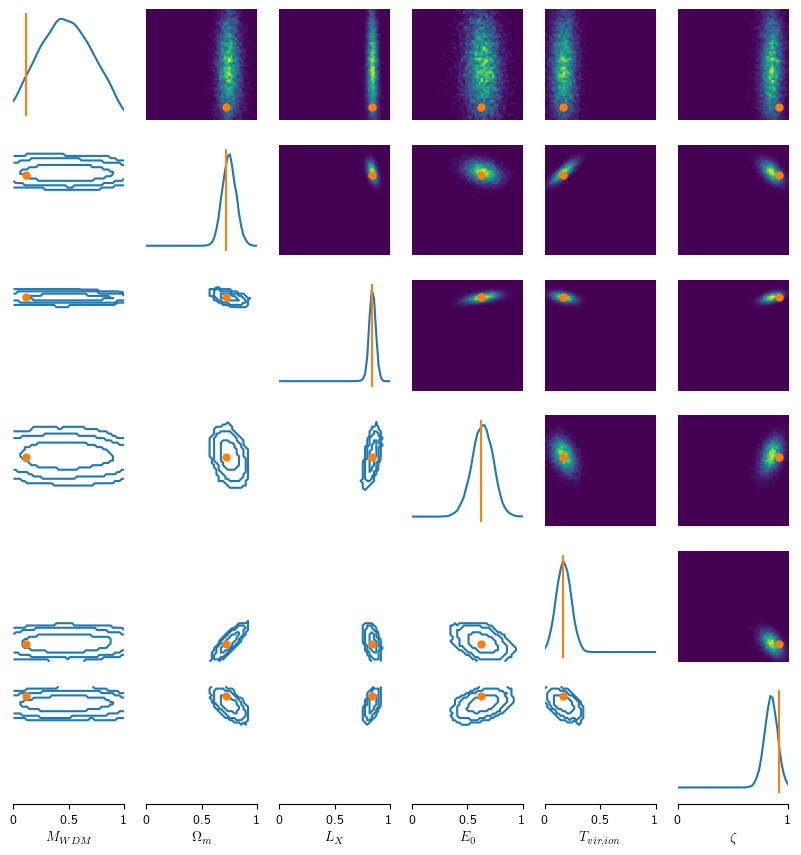

In [ ]:
'''prior = (lambda x: x)
sbi = SBIHandler(density_estimator=model_de, summary_net=model_sn.Model, device=device)
sbi.load_model()'''

lab, img, _ = test_dataloader.dataset[3]

lab, img = lab.to(device), img.to(device)
img = img.unsqueeze(0)

summary = sbi.summary_net(img)

samples, _ = sbi.density_estimator.sample(10000, summary)
print(samples.shape)
# plot posterior samples
figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
       limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
       labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
       #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
       upper = 'hist', lower = 'contour', diag = 'kde')
figure.savefig("inn_40.png", dpi=300)
figure.show()

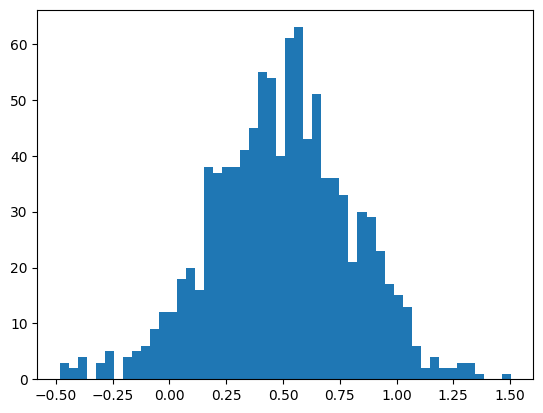

torch.Size([1000, 1, 6])


In [ ]:
plt.hist(posterior.posterior_estimator.sample((1000,), summary_vec[0].unsqueeze(0))[:,0,0].detach().cpu().numpy(), bins=50)
plt.show()

In [16]:
### SNPE ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE
from sbi import utils, analysis
from sbi.utils import RestrictedPrior, get_density_thresholder

# load the summary model
model = SumnetHandler(Model = Summary_net_lc_super_smol, device=device)
model.load("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=128, num_transforms=6, z_score_theta='none',
    z_score_x='none', batch_norm=True
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=99,
                                    stop_after_epochs=99,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)


for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample(nsamples, summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()


/tmp/ipykernel_22817/2487484646.py:17: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator_build_fun = posterior_nn(
/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:153: UserWarning: Data x has device 'cpu'. Moving x to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(
/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:153: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'. Training will proceed on device 'cuda'.
  theta, x = validate_theta_and_x(


on 0: test_loss_density_net[-1]=-6.702829224722726 test_loss_summary_net[-1]=0.01648982350847551
on 1: test_loss_density_net[-1]=-7.252196598052978 test_loss_summary_net[-1]=0.01649940556713513
on 2: test_loss_density_net[-1]=-7.205811773027692 test_loss_summary_net[-1]=0.0164334258596812
on 3: test_loss_density_net[-1]=-7.38113557270595 test_loss_summary_net[-1]=0.016475331038236618
on 4: test_loss_density_net[-1]=-7.245266492026193 test_loss_summary_net[-1]=0.0165837419086269
on 5: test_loss_density_net[-1]=-7.688181727273124 test_loss_summary_net[-1]=0.01643612113382135
on 6: test_loss_density_net[-1]=-7.252720751081195 test_loss_summary_net[-1]=0.016432591607528073
on 7: test_loss_density_net[-1]=-7.568658174787249 test_loss_summary_net[-1]=0.01642952963177647
on 8: test_loss_density_net[-1]=-7.589473479134696 test_loss_summary_net[-1]=0.016447445031787668
on 9: test_loss_density_net[-1]=-7.691467939104353 test_loss_summary_net[-1]=0.016487999553126947
on 10: test_loss_density_net[

/home/potato/Documents/projects/master/ml-venv/lib/python3.11/site-packages/sbi/inference/snpe/snpe_base.py:453: UserWarning: Maximum number of epochs `max_num_epochs={max_num_epochs}` reached,but network has not yet fully converged. Consider increasing it.
  self._report_convergence_at_end(self.epoch, stop_after_epochs, max_num_epochs)


TypeError: 'int' object is not iterable

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

/tmp/ipykernel_22817/3139476204.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

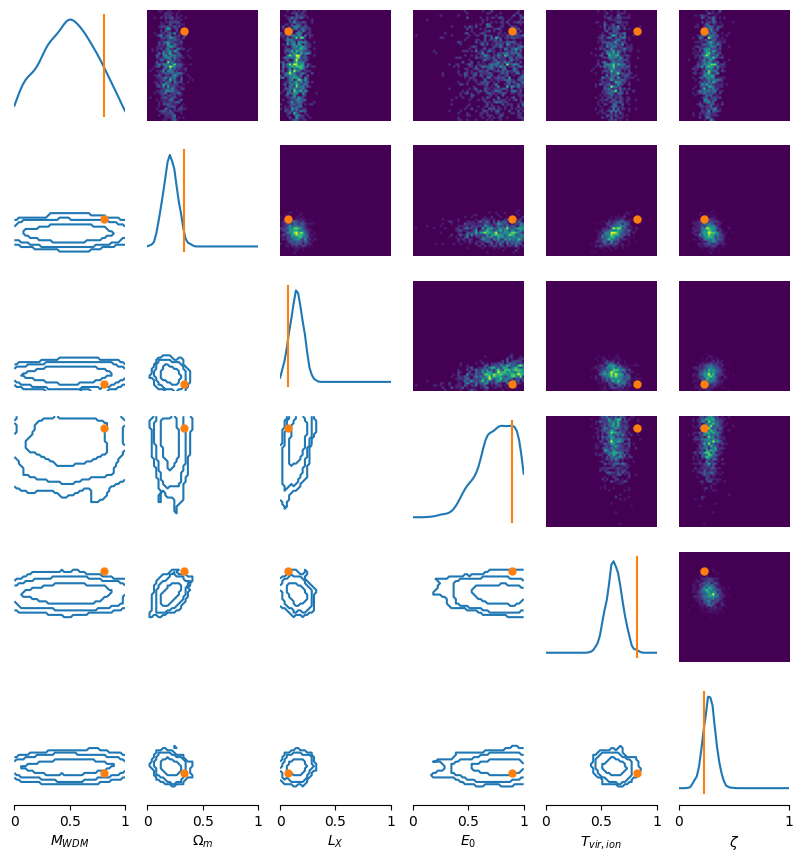

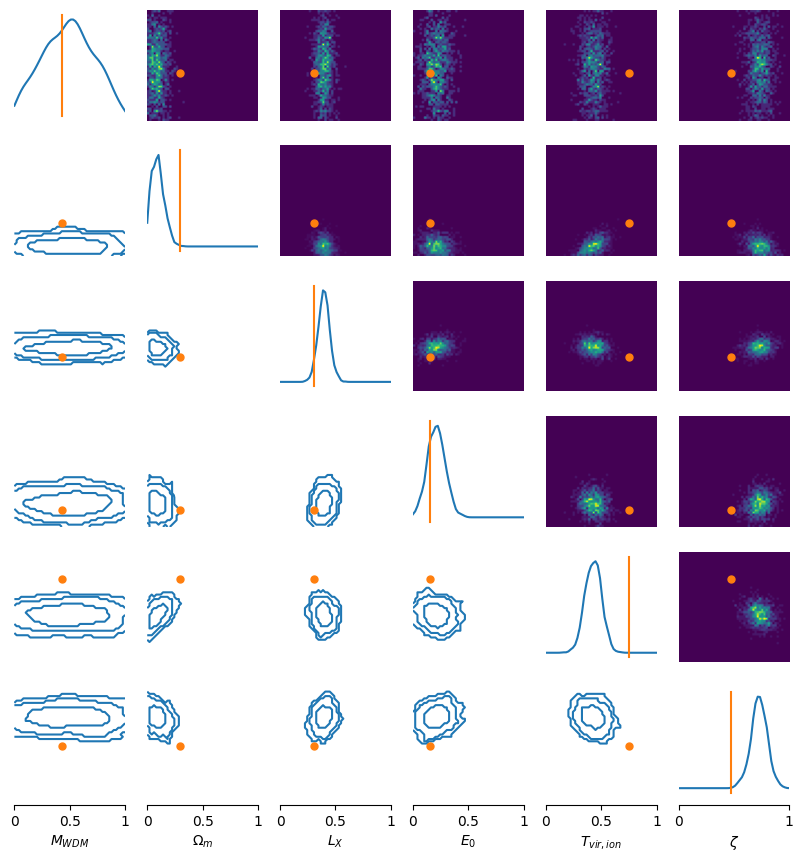

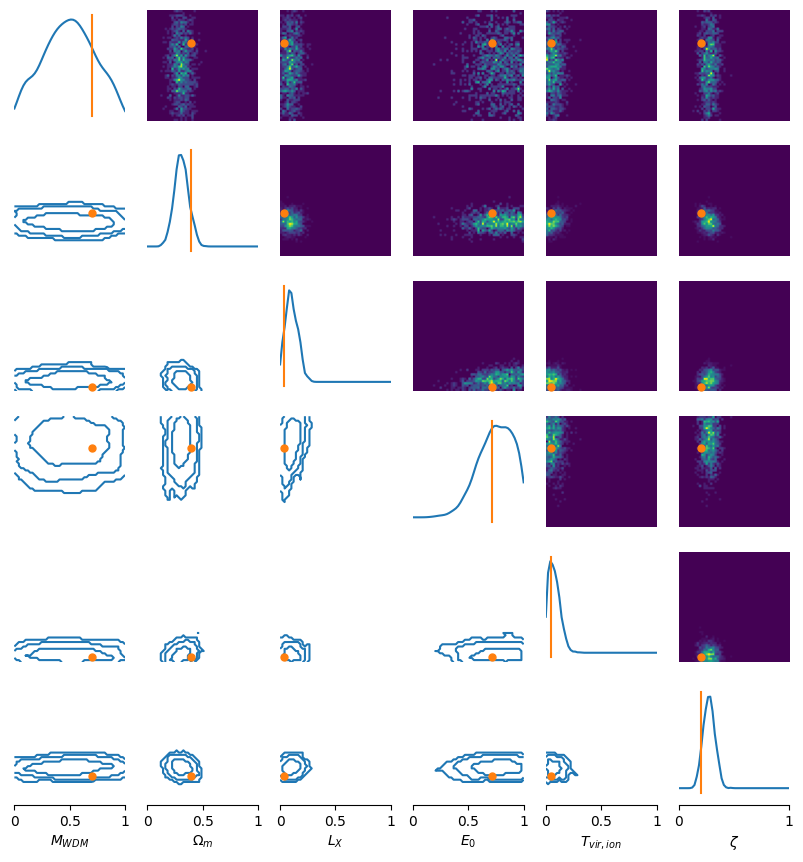

In [17]:
for i in range(3):
    lab, img, _ = test_dataloader.dataset[i]

    lab, img = lab.to(device), img.to(device)
    img = img.unsqueeze(0)

    summary = sbi.summary_net(img).detach()
    cond_size = summary.shape[-1]
    nsamples = 1000
    samples = posterior.sample((nsamples,), summary)
    # plot posterior samples
    figure, axis = analysis.pairplot(samples = samples.detach().to('cpu').numpy(), points=lab.detach().to('cpu').numpy(),
        limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(10, 10),
        labels = [r"$M_{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_{vir, ion}$", r"$\zeta$"],
        #quantiles=((0.16, 0.84, 0.0015, 0.99815)), levels=(1 - np.exp(-0.5),1 - np.exp(-9/2)),
        upper = 'hist', lower = 'contour', diag = 'kde')
    if save: figure.savefig(f"maf_theirs_{i}.png", dpi=300)
    figure.show()

In [ ]:
### SNPE - backup ###

from sbi.utils.get_nn_models import (
    posterior_nn,
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6, z_score_theta='none',
    z_score_x='none', 
)

# train the maf
inference = SNPE(prior=prior, density_estimator=density_estimator_build_fun, device=device)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]


density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=5,
                                    stop_after_epochs=20,
                                    max_num_epochs=20,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    #fig.savefig(f"./NPE_{i}.png", dpi=300)

In [ ]:
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )

In [ ]:
for i in range(10):
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)

    x = x.to(device)

    x = model.Model(x).detach()
    sample, prob = density_net.sample_and_log_prob(sample_shape=torch.tensor([1]), condition=x.to('cuda'))
    print("summary-vec = ", x)
    print("true-vec = ", y)
    print("sample-vec = ", sample.detach())
    print("prob = ", prob.item())
    print()
    

In [ ]:
?

In [ ]:
torch.unsqueeze(train_dataloader.dataset.__getitem__(0)[1],0).shape

In [ ]:
with open("delete.me", "wb") as handle:
    pickle.dump(density_net, handle)

In [ ]:
train_loss_summary_net, train_loss_density_net, test_loss_summary_net, test_loss_density_net = statistics
plt.plot(train_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{train}}$')
plt.plot(np.asarray(train_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{train}}$')   
plt.plot(test_loss_summary_net, label=r'$\log \mathcal{L}_{\Phi_{test}}$')
plt.plot(np.asarray(test_loss_density_net)/32, label=r'$\log \mathcal{L}_{\varphi_{test}}$')
plt.vlines(9, 0.5, 0, color='b', label='joint learning', colors='black')
plt.legend()
#plt.savefig("NPE_nsf_joint_loss.png", dpi=400)
plt.show()


In [ ]:
### NRE ###


from sbi.utils.get_nn_models import (
    classifier_nn
)  # For SNPE: posterior_nn(), SNLE: likelihood_nn(). For SNRE: classifier_nn()
from sbi.inference import SNRE
from sbi import utils, analysis

# load the summary model
model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("./summary_net2.pt")

prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)), device=device)

# define the maf
ratio_estimator = classifier_nn(
    model = 'resnet', z_score_x='none',  z_score_theta='none'
)

# train the maf
inference = SNRE(prior=prior, device=device, classifier=ratio_estimator)

y,x,idx = train_dataloader.dataset()

inference.append_simulations(y,y)

inference.train_indices = [0]

density_net, summary_net, statistics = inference.train(train_dataloader=train_dataloader,
                                    test_dataloader=test_dataloader,
                                    optimizer=optimizer,
                                    optimizer_parameter=optimizer_params,
                                    summary_net=model.Model,
                                    train_summary_net_freezed_rounds=50,
                                    stop_after_epochs=10,
                                    max_num_epochs=0,
                                    clip_max_norm=None)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_net, prior=prior)

for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    y,x,_ = test_dataloader.dataset.__getitem__(i)
    y,x = y.unsqueeze(0), x.unsqueeze(0)
    print(y.shape, x.shape)

    x = x.to(device)
    
    x = summary_net(x)

    posterior_samples = posterior.sample((10000,), x=x).to('cpu')

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y

    )
    
    fig.savefig(f"./NRE_{i}.png", dpi=300)

In [ ]:
from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot

In [ ]:
from sbi.utils.torchutils import repeat_rows
from torch import eye, ones
num_atoms=10

y,x,_ = test_dataloader.dataset.__getitem__(0)
y,x = y.unsqueeze(0), x.unsqueeze(0)
print(y.shape, x.shape)
x = model.Model(x)

y1, x1,_ = test_dataloader.dataset.__getitem__(1)
y1,x1 = y1.unsqueeze(0), x1.unsqueeze(0)
x1 = model.Model(x1)

y, x = torch.cat((y,y1)), torch.cat((x,x1))

batch_size = y.shape[0]
print(f'{batch_size=}')

repeated_x = repeat_rows(x, num_atoms)
print(f'{repeated_x=}')

# Choose `1` or `num_atoms - 1` thetas from the rest of the batch for each x.
probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
print(f'{probs=}')

choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)

In [ ]:

# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))

In [ ]:
# take closer look at test
ModelHandler.test_specific(test_dataloader, model.Model, loss(**loss_params), 1, denormalize=test_data.denormalize)

# save the model
#model.save_model(name = "summary_net.pt")

In [ ]:
from sbi.inference import SNPE, SNLE
from sbi import utils, analysis

# define model hyperparemeter
user_params = {
"HII_DIM": 40,
"BOX_LEN": 160,
"N_THREADS": 2,
"USE_INTERPOLATION_TABLES": True,
"PERTURB_ON_HIGH_RES": True
}

flag_options = {
"INHOMO_RECO": True,
"USE_TS_FLUCT": True
}

#simparams = p21c.outputs.LightCone.read("./data/run_36690")
# load the simulator class
Leaf_simulator = Leaf(debug=True, user_params=user_params, flag_options=flag_options, redshift = 5.5)

# define the prior ranges (only need for denormalization!)
prior_range = torch.tensor([
            [0.3,10.0], # M_WDM
            [0.2,0.4], # OMm
            [38, 42], # L_X
            [100, 1500], # NU_X_THRESH
            [4, 5.3], # ION_Tvir_MIN
            [10.0, 250.0], # HII_EFF_FACTOR
], dtype = torch.float32)

# define the prior (uniform prior in this case)
prior = utils.BoxUniform(low=torch.zeros((6)), high=torch.ones((6)))


'''# define the simulator
def simulation(theta):
    M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR = theta
    cosmo_params = {
        "OMm": OMm.item()
        }
    astro_params = {
        "L_X": L_X.item(),
        "NU_X_THRESH": NU_X_THRESH.item(),
        "ION_Tvir_MIN": ION_Tvir_MIN.item(),
        "HII_EFF_FACTOR": HII_EFF_FACTOR.item(),
        "INHOMO_RECO": True
    }
    global_params = {
        "M_WDM": M_WDM.item()
    }


    return Model.fast_forward(torch.as_tensor(Leaf_simulator.run_lightcone(
        save = False, sanity_check = True, filter_peculiar = False, debug=False,
        astro_params = astro_params, global_params = global_params, cosmo_params = cosmo_params).brightness_temp, dtype=torch.float32))


def simulator(theta: torch.FloatTensor, Model: object, threads: int = 1):
    tshape = theta.shape
    schwimmhalle = Pool(max_workers=threads, max_tasks_per_child=1, mp_context=get_context('spawn'))
    runner = [params for params in theta]
    result = []
    with alive_bar(len(runner), force_tty=True) as bar: 
        with schwimmhalle as p:
            data = p.map(simulation, runner)
            for dat in data:
                lc_bt = future.result()

                dat.add_done_callback(bar())
    return data
'''

In [ ]:
# check if simulator is working
#prepare_for_sbi(prior = prior, simulator = simulation)

In [ ]:
# define point of interest
# [M_WDM, OMm, L_X, NU_X_THRESH, ION_Tvir_MIN, HII_EFF_FACTOR]
x_o = torch.tensor([2, 0.30964144154550644, 40.0, 500.0, 4.69897, 30.0], dtype=torch.float32)

# A PPC is performed after we trained or neural posterior
posterior.set_default_x(x_o)

# We draw theta samples from the posterior. This part is not in the scope of SBI
if __name__ == '__main__':
    posterior_samples = posterior.sample((5000,))

# We use posterior theta samples to generate x data
    x_pp = torch.as_tensor(simulator(theta = posterior_samples, Model = model, threads=6))

# We verify if the observed data falls within the support of the generated data
_ = analysis.pairplot(
    samples=x_pp,
    points=x_o
)

In [ ]:
### SNLE ###

from sbi.utils.get_nn_models import (
    likelihood_nn,
)  

# load the summary model
model = ModelHandler(Model = Summary_net_lc_smol, device='cpu')
model.load_model("./summary_net.pt")

# define the maf
density_estimator_build_fun = posterior_nn(
    model="maf", hidden_features=60, num_transforms=6
)

# do inference using a freezed summary model
x,y = model.full_inference(train_dataloader)

# train the maf
inference = SNLE(prior=prior, density_estimator=density_estimator_build_fun)
inference.append_simulations(y,x)
density_estimator = inference.train()
# infere test data
x,y = model.full_inference(test_dataloader)

# sample the posterior using the first 3 parameters from the testset
posterior = inference.build_posterior(density_estimator, prior=prior)
for i in range(3):
    
    #idx = np.random.randint(0,x.shape[0])
    idx = i
    posterior_samples = posterior.sample((10000,), x=x[idx,:], num_workers=10, method="slice_np_vectorized", num_chains=10)

    # plot posterior samples
    fig, ax = analysis.pairplot(
        posterior_samples, limits=[[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],[0, 1],], figsize=(5, 5),
        labels = ["M_WDM", "OMm", "L_X", "NU_X_THRESH", "ION_Tvir_MIN", "HII_EFF_FACTOR"],
        points= y[idx]

    )
    
    fig.savefig(f"./NLE_{i}.png", dpi=300)

In [ ]:
train_data = DataHandler(path="./data/", prefix="batch", load_to_ram=False,
                         split = train_test_data_ration, training_data = True,
                         apply_norm=True, norm_range=norm_range, augmentation_probability=.5)
# import data to torch dataloader
train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True,
                              num_workers = 2, pin_memory = True, prefetch_factor=2)

In [ ]:
for dat in train_dataloader:
    img, _,_ = dat
    print(img.shape)
    plt.imshow(img[0,0,:,:,0])
    break

In [ ]:
data = torch.rand((100,100,100))
%timeit noise1(data)

In [ ]:
test = 0 if 0 == 1 elif

In [ ]:
from sbi import utils, analysis

from sbi.diagnostics import check_sbc, run_sbc
from sbi.analysis import sbc_rank_plot
import corner
import numpy as np
import arviz
import pickle
from sbi.inference.posteriors import MCMCPosterior

In [ ]:
with open("../NRE_de.pkl", "rb") as handle:
    posterior = pickle.load(handle)

posterior.potential_fn.device = 'cpu'
posterior = MCMCPosterior(potential_fn=posterior.potential_fn,
                          proposal=posterior.proposal,
                          theta_transform=posterior.theta_transform,
                          method='slice_np_vectorized',
                          thin=posterior.thin,
                          warmup_steps=posterior.warmup_steps,
                          num_chains=6,
                          num_workers=6,
                          device='cpu')

model = ModelHandler(Model = Summary_net_lc_super_smol, device=device)
model.load_model("../NRE_sn.pt")
sum_net = model.Model

with torch.no_grad():
    with alive_bar(len(test_dataloader), force_tty=True, refresh_secs=1) as bar:
        for i, (lab, img,_) in enumerate(test_dataloader):
            img, lab = img.to(device), lab.to(device)
            
            if not i:
                summary_vec = torch.empty(0,lab.shape[1], device=device)
                labels = torch.empty(0,lab.shape[1], device=device)

            pred = sum_net(img)
            summary_vec = torch.cat((summary_vec, pred), dim=0)
            labels = torch.cat((labels, lab), dim=0)
            bar()

xs = summary_vec
thetas = labels
num_sbc_runs = xs.shape[0]
num_posterior_samples = num_sbc_runs

#xs, thetas = model.full_inference(sbc_dataloader)

ranks, dap_samples = run_sbc(
    thetas, xs, posterior, num_posterior_samples=num_posterior_samples
)

check_stats = check_sbc(
    ranks, thetas, dap_samples, num_posterior_samples=num_posterior_samples
)

print(
    f"kolmogorov-smirnov p-values \ncheck_stats['ks_pvals'] = {check_stats['ks_pvals'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)
print(
    f"c2st accuracies \ncheck_stats['c2st_ranks'] = {check_stats['c2st_ranks'].numpy()}"
)

fig, ax = sbc_rank_plot(
    ranks=ranks,
    num_posterior_samples=num_posterior_samples,
    plot_type="hist",
    num_bins=None,  # by passing None we use a heuristic for the number of bins.
    parameter_labels = [r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],
)

fig.savefig("NRE_sbc_rank_maf_freezed_sum.png", dpi=300)

fig, ax = sbc_rank_plot(ranks, 1_000, plot_type="cdf", parameter_labels=[r"$M_\text{WDM}$", r"$\Omega_m$", r"$L_X$", r"$E_0$", r"$T_\text{vir, ion}$", r"$\zeta$"],)
fig.savefig("NRE_sbc_CDF_maf_freezed_sum.png", dpi=300)

In [ ]:
posterior.potential_fn

In [ ]:
for x,y,_ in train_dataloader:
    print(x.shape, y.shape)
    breal

In [ ]:
from torch.utils.data import TensorDataset
data_x, data_y = torch.zeros(100,1,28, 28, 470), torch.zeros(100,6)
dummy_idx = torch.zeros(100)

for i in range(100):
    if torch.rand(1).item()<0.5:
        data_x[i] = torch.ones(1,28, 28, 470)
        data_y[i] = torch.ones(6)


batch_size = 16
epochs = 5
train_test_data_ration = 0.9

optimizer = torch.optim.Adam
optimizer_params = {
    "lr": 1e-3,
}

loss = torch.nn.MSELoss
loss_params = {}

dataset_train = TensorDataset(data_y[:80], data_x[:80], dummy_idx[:80])
dataset_test = TensorDataset(data_y[80:], data_x[80:], dummy_idx[80:])

dataset_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)


model = ModelHandler(Model = Summary_net_lc_super_smol,
                     Training_data=dataset_train, Test_data=dataset_test, device=device)


# train
model.train(
    epochs=epochs,
    optimizer=optimizer(
        model.Model.parameters(),
        **optimizer_params),
        lossf=loss(**loss_params))

# test
#model.test(Validation_data = test_dataloader, Model = model.Model, lossf=loss(**loss_params))